In [1]:
#say no to warnings!
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import albumentations as A

from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50,resnet50,MobileNetV2,mobilenet_v2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix


# Dataset


The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

In [3]:
cifar_dataset = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar_dataset.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [4]:
print("Train dataset is composed by {} images".format(train_images.shape[0]))
print("Test dataset is composed by {} images".format(test_images.shape[0]))

Train dataset is composed by 50000 images
Test dataset is composed by 10000 images


In [5]:
label_dict = {
    0:"airplane",
    1:"automobile",
    2:"bird",
    3:"cat",
    4:"deer",
    5:"dog",
    6:"frog",
    7:"horse",
    8:"ship",
    9:"truck"
}

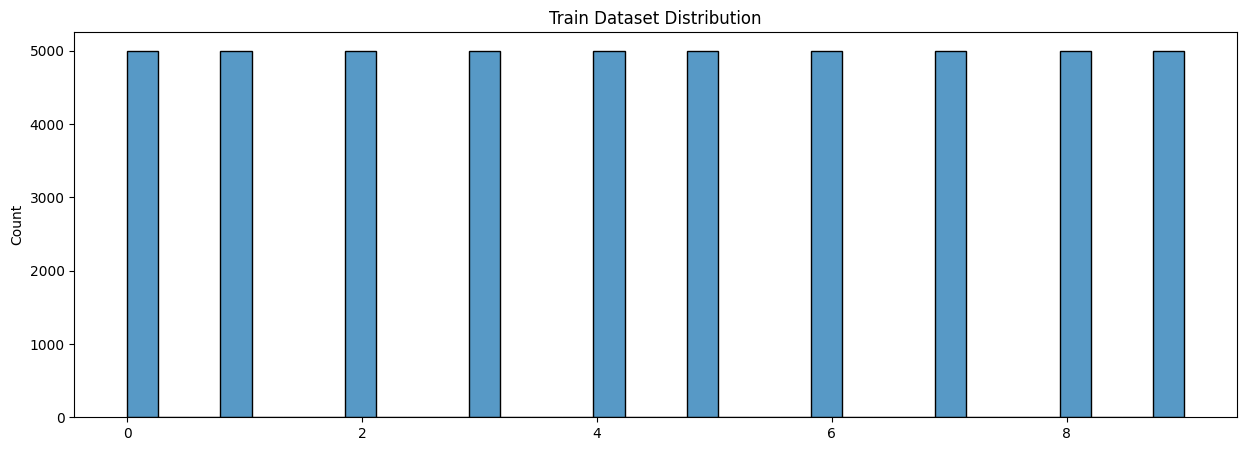

In [6]:
plt.figure(figsize=(15,5))
sns.histplot(x = train_labels.reshape(-1))
plt.title("Train Dataset Distribution")
plt.show()

In [7]:
print("Size of image is: {} x {}".format(train_images.shape[1],train_images.shape[2]))

Size of image is: 32 x 32


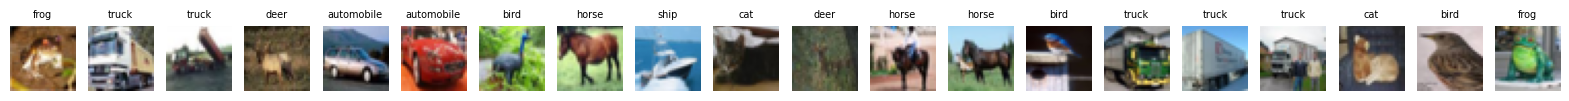

In [8]:
plt.figure(figsize=(20,20))
for i in range(0,20):
    plt.subplot(1,20,i+1)
    plt.imshow(train_images[i], cmap=plt.cm.gray)
    plt.title(label_dict[int(train_labels[i])],fontsize = 7)
    plt.axis('off')

In [9]:
# convert airplane and automobile values into  1 that represent vehicle otherwise 0 for animals
modify_function = lambda x: 1 if x in [0,1,8,9 ] else 0

In [10]:
train_labels_bin = np.array(list(map(modify_function, train_labels)))
test_label_bin = np.array(list(map(modify_function, test_labels)))

In [11]:
cat_train_label = to_categorical(train_labels_bin,2)
cat_test_label = to_categorical(test_label_bin,2)

In [12]:
number_of_vehicle = np.count_nonzero(train_labels_bin)
number_of_animal = np.count_nonzero(train_labels_bin==0)
print("Numbero of vehicle in the train dataset: {}".format(number_of_vehicle))
print("Numbero of animal in the train dataset: {}".format(number_of_animal))

Numbero of vehicle in the train dataset: 20000
Numbero of animal in the train dataset: 30000


As we can see the number of vehicle and animals are not the same but it can be considered as balanced

# Image Resize and Pre_Processing

In [13]:
class Image_Processing():
  """
  This class aim to resize the image with a specifc one and perform the preprocessing
  using those from the models

  input:
    TrainDataset --> train dataset
    TestDataset --> test dataset
    size --> size of the image to resize
  """
  def __init__(self,TrainDataset,TestDataset,size=[224,224]):

    train_images,train_labels_bin = TrainDataset
    test_images,test_label_bin = TestDataset

    self.train_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_labels_bin))
    self.test_dataset = tf.data.Dataset.from_tensor_slices((test_images,test_label_bin))
    self.size = size

  def start_processing(self,model):
    """
    Method that run all process in order to achieve the resize and the preprocessing

    input:
      model --> model of which  preprocessing is used

    output :
      train_dataset --> train dataset after resize and preprocessing
      test_dataset --> test dataset after resize and preprocessing
    """
    self.model = model
    train, test = self._map_func()
    train_dataset , test_dataset  = self._shuffle_and_batch(train,test)
    return train_dataset,test_dataset


  def __resize_and_preproc(self,image,label):
    """
    Function used to resize and preprocess dataset.
    Since we used this method in map and the dataset are composed by image and label
    in order that map function works needed to call image and label inside this method
    """
    image = tf.image.resize(image, self.size)
    img_processed = self.model.preprocess_input(image)
    return img_processed,label

  def _map_func(self):
    """
    Map of the _resize_and_preproc function to the dataset

    input:
      None

    output:
      train_dataset --> train dataset after resize and preprocessing
      test_dataset --> test dataset after resize and preprocessing
    """
    train_dataset = self.train_dataset.map(self.__resize_and_preproc, num_parallel_calls=tf.data.AUTOTUNE)
    test_dataset = self.test_dataset.map(self.__resize_and_preproc, num_parallel_calls=tf.data.AUTOTUNE)
    return train_dataset, test_dataset

  def _shuffle_and_batch(self,train,test,batch=32):
    """
    Function that shuffle and batch the dataset

    input :
      train --> traindìaset after resize and preprocessing
      test --> test dataset after resize and preprocessing
      batch --> batch size

    output :
      train_dataset --> train dataset shuffled and batched
      test_dataset --> test dataset shuffled and batched
    """
    batch_size = batch
    train_dataset = train.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_dataset = test.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    for images, labels in train_dataset.take(1):
      print("---------------------------")
      print("Train Dataset")
      print("Images shape:", images.shape)
      print("Labels shape:", labels.shape)

    for images, labels in test_dataset.take(1):
      print("---------------------------")
      print("Test Dataset")
      print("Images shape:", images.shape)
      print("Labels shape:", labels.shape)

    return train_dataset,test_dataset




In [14]:
img_proc = Image_Processing((train_images,train_labels_bin),(test_images,test_label_bin))

# Models



In [15]:
def make_transfert_model(model,num_non_trainable_layers:int=0):
  """
  Function that create a model where only the last layers are trainable.
  The last layers are:
  - GlobalAveragePooling2D
  - A Dense layer of 1024 neurons with relu activation
  - A Dense layer of 1 neuron with sigmoid activation for the binary classification


  input:
    model --> model to perform modication
    num_non_trainable_layer --> the layers numbert that are not trainable if 0 all layers are trainable


  output:
    transfert_model --> the modified model
  """


  x = model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(1024, activation='relu',name='my_layer_1')(x)
  preds = Dense(1,name='my_layer_3', activation ='sigmoid')(x)
  transfert_model = Model(inputs=model.input, outputs=preds)

  if num_non_trainable_layers > 0:
    for layer in transfert_model.layers[:num_non_trainable_layers]:
      layer.trainable = False
    for layer in transfert_model.layers[num_non_trainable_layers:]:
      layer.trainable = True

  transfert_model.summary()

  return transfert_model

## MobileNetV2


In [16]:
# pre_processing for dataset
preproc_train_mobilenet = mobilenet_v2.preprocess_input(train_images)
preproc_test_mobilenet = mobilenet_v2.preprocess_input(test_images)

In [17]:
# model creation. MobileNetV2 weitghts are already imported.
mobile_net_v2_model = MobileNetV2(weights='imagenet',
                                  include_top=False,
                                  input_shape=(224,224,3)
                                  )

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [18]:
# get the number of layer that we don't need to train since we used imagenet weigts
num_non_trainable_layers = len(mobile_net_v2_model.layers)
print("The total number of layers that don't need to be trained is: {}".format(num_non_trainable_layers))

The total number of layers that don't need to be trained is: 154


In [19]:
# transfert model creation
transfert_mobile_net_v2 = make_transfert_model(mobile_net_v2_model,num_non_trainable_layers)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 3,570,753 (13.62 MB)

 Trainable params: 1,312,769 (5.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [20]:
# compile the model
transfert_mobile_net_v2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','binary_accuracy'])

## ResNet50

In [21]:
# some image pre-processing is needed before model's training
preproc_train_resnet50 = resnet50.preprocess_input(train_images)
preproc_test_resnet50 = resnet50.preprocess_input(test_images)

In [22]:
# model's creation
resnet50_model = ResNet50(weights='imagenet',
                                  include_top=False,
                                  input_shape=(224,224,3)
                                  )

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [23]:
# get the number of layer that we don't need to train since we used imagenet weigts
num_non_trainable_layers = len(resnet50_model.layers)
print("The total number of layers that don't need to be trained is: {}".format(num_non_trainable_layers))

The total number of layers that don't need to be trained is: 175


In [24]:
# transfert model creation
transfert_resnet50 = make_transfert_model(resnet50_model,num_non_trainable_layers)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [25]:
transfert_resnet50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy',"accuracy"])

# Training


In [26]:
def early_stopping_func(monitor_value:str, n_patience:int, mode:str):
  """
  That function create an early stopping

  inputs:
    monitor_value -->  quantity to be monitored
    n_patience -->  Number of epochs with no improvement after which training will be stopped.
    mode --> One of {"auto", "min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing;
             in "max" mode it will stop when the quantity monitored has stopped increasing;
             in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.

  output:
    early_stop --> early stopping object
  """
  early_stop = EarlyStopping(monitor=monitor_value, patience=n_patience, verbose=1, mode=mode)
  return early_stop

In [27]:
def fit_model(model,dataset,val_data,epoch:int):
  """
  This Function calls the model's trainig with early_stopping

  input:
      model --> model to train
      dataset --> train dataset
      val_data --> validation dataset
      epoch --> numbero of training epochs

  output:
      history --> return the model hystory
      model --> trained model
  """
  early_stopping = early_stopping_func('val_loss',5,"min")
  history = model.fit(dataset,
                      validation_data = val_data,
                      epochs = epoch,
                      callbacks=[early_stopping])

  return history, model


In [28]:
train_dataset_mobv2 ,test_dataset_mobv2 = img_proc.start_processing(mobilenet_v2)

---------------------------
Train Dataset
Images shape: (32, 224, 224, 3)
Labels shape: (32,)
---------------------------
Test Dataset
Images shape: (32, 224, 224, 3)
Labels shape: (32,)


In [29]:
train_dataset_mobv2

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [30]:
mobile_history, mobile_trained  = fit_model(model = transfert_mobile_net_v2,
                                            dataset = train_dataset_mobv2,
                                            val_data = test_dataset_mobv2,
                                            epoch = 50)

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 102s 57ms/step - accuracy: 0.9518 - binary_accuracy: 0.9518 - loss: 0.1247 - val_accuracy: 0.9752 - val_binary_accuracy: 0.9752 - val_loss: 0.0640
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 118s 46ms/step - accuracy: 0.9753 - binary_accuracy: 0.9753 - loss: 0.0657 - val_accuracy: 0.9733 - val_binary_accuracy: 0.9733 - val_loss: 0.0649
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 71s 45ms/step - accuracy: 0.9809 - binary_accuracy: 0.9809 - loss: 0.0538 - val_accuracy: 0.9772 - val_binary_accuracy: 0.9772 - val_loss: 0.0623
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 84s 46ms/step - accuracy: 0.9834 - binary_accuracy: 0.9834 - loss: 0.0442 - val_accuracy: 0.9785 - val_binary_accuracy: 0.9785 - val_loss: 0.0674
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 46ms/step - accuracy: 0.9873 - binary_accuracy: 0.9873 - loss: 0.0342 - val_accuracy: 0.9778 - val_binary_accuracy: 0.9778 - val_loss: 0.0760
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 70s 44ms/step - 

In [31]:
train_dataset_res ,test_dataset_res = img_proc.start_processing(resnet50)

---------------------------
Train Dataset
Images shape: (32, 224, 224, 3)
Labels shape: (32,)
---------------------------
Test Dataset
Images shape: (32, 224, 224, 3)
Labels shape: (32,)


In [32]:
res_history, res_trained = fit_model(model = transfert_resnet50,
                                     dataset = train_dataset_res ,
                                     val_data = test_dataset_res,
                                     epoch=50)

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 214s 127ms/step - accuracy: 0.9688 - binary_accuracy: 0.9688 - loss: 0.1054 - val_accuracy: 0.9831 - val_binary_accuracy: 0.9831 - val_loss: 0.0440
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 202s 128ms/step - accuracy: 0.9873 - binary_accuracy: 0.9873 - loss: 0.0357 - val_accuracy: 0.9870 - val_binary_accuracy: 0.9870 - val_loss: 0.0341
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 188s 119ms/step - accuracy: 0.9905 - binary_accuracy: 0.9905 - loss: 0.0278 - val_accuracy: 0.9890 - val_binary_accuracy: 0.9890 - val_loss: 0.0321
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 190s 120ms/step - accuracy: 0.9926 - binary_accuracy: 0.9926 - loss: 0.0212 - val_accuracy: 0.9848 - val_binary_accuracy: 0.9848 - val_loss: 0.0486
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 214s 128ms/step - accuracy: 0.9944 - binary_accuracy: 0.9944 - loss: 0.0154 - val_accuracy: 0.9902 - val_binary_accuracy: 0.9902 - val_loss: 0.0336
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 189s 120

# Evaluation

In [33]:
def find_min_max(hist):
  min = 0
  max = 0
  values = []
  values.append(hist.history['loss'])
  values.append(hist.history['val_loss'])
  min = float(np.min(values)) *0.50
  max = float(np.max(values)) *1.50
  return min,max


In [34]:
def create_plot(hist,label=""):
  """
  This function create the accuracy and loss plots.

  input :
    hist = model.history
    label = label for the plot

  output :
    None
  """
  plt.figure(figsize=(12,4))
  plt.subplot(1,2,1)
  plt.plot(hist.history['accuracy'], label='acc')
  plt.plot(hist.history['val_accuracy'], label='val_acc')
  plt.title(label+" Accuracy")
  plt.ylim(0,1)
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(hist.history['loss'], label='loss')
  plt.plot(hist.history['val_loss'], label='val_loss')
  plt.legend()
  plt.title(label+" Loss")

In [35]:
def plot_confusion_matrix(y_true,y_pred,labels=["Negative","Positive"],label=""):
  """
  This function create confusion matrix of the model.
  input:
    y_true --> true label dataset
    y_pred --> model's prdediction
    labels --> labels to use in the confusion matrix
    label --> label for the plot

  output:
    None
  """
  y_pred = set_correct_label(y_pred)
  cm = confusion_matrix(y_true,y_pred)
  df_cm = pd.DataFrame(cm,index=labels,
                       columns = ["Predicted" + labels[0] ,"Predicted"+labels[1]])
  sns.heatmap(df_cm , annot=True , fmt ="g")
  plt.title(label + " Confusion Matrix")

In [36]:
def print_evaluation(model,dataset,label):
  X_test, y_test = dataset
  result = model.evaluate(X_test,y_test)
  print(result)

In [37]:
def set_correct_label(model_prediciton,value:float=0.5):
  """
  This fucntion set the correct prediction based on the probability value of the model's predictio
  By default the trigger value is 0.5

  input :
    model_prediction --> model's prediction
    value --> trigger value setted as default to '.5

  output:
    model_prediction --> model's prediction with the correct label binary
  """
  correction_function = lambda x: 1 if x > value else 0
  return np.array(list(map(correction_function, model_prediciton)))


## MobileNetV2

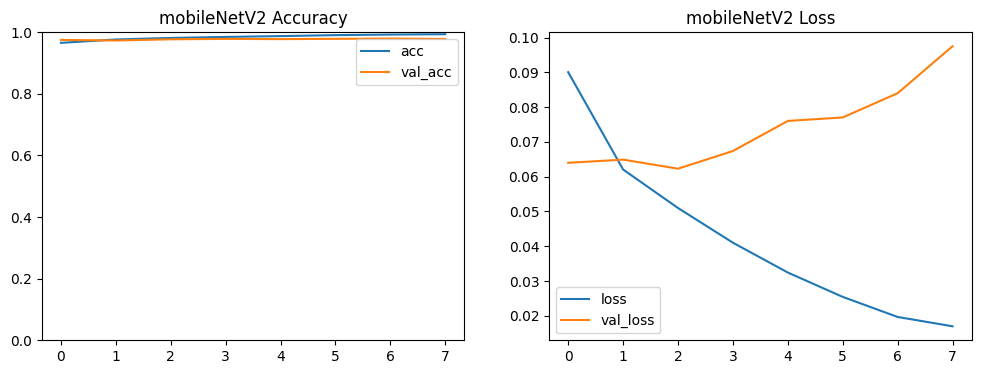

In [38]:
# mobile net v2 plotting
create_plot(mobile_history,label="mobileNetV2")

313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step


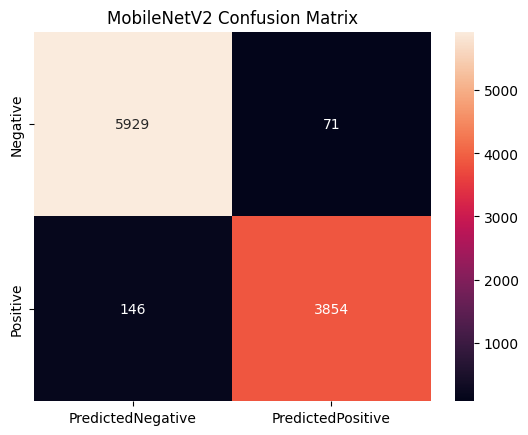

In [39]:
plot_confusion_matrix(test_label_bin,mobile_trained.predict(test_dataset_mobv2),label="MobileNetV2")

## ResNet50

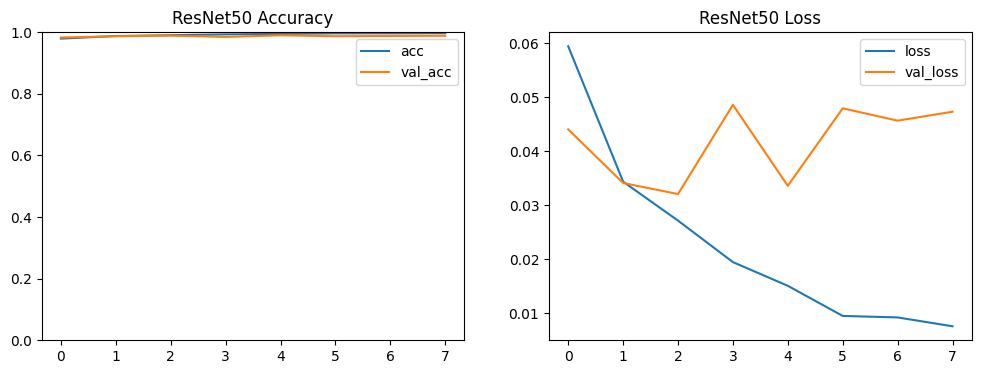

In [40]:
#resnet 50 plotting
create_plot(res_history,label="ResNet50")

313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step


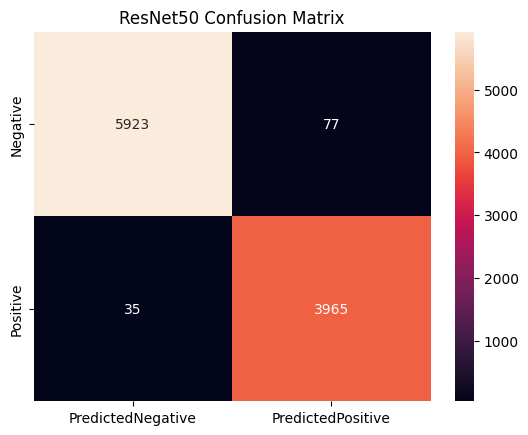

In [41]:
plot_confusion_matrix(test_label_bin,res_trained.predict(test_dataset_res),label="ResNet50")

# Performance Investigation

In [42]:
def find_error(model_prediciton, true_label_bin, all_category_label):
  """
  This function find the label and the relative index of a wrong prediction

  input:
    model_prediction --> model's prediction
    true_label_bin --> true binary labels (0 or 1)
    all_category_label -->  true label with real value (0 to 9)

  return:
    model_prediction_label --> categorical label prediction with "Animal" or "Not Animal"
    index_error --> index of the wrong prediction
    all_category_label --> true label  with real value (0 to 9) that were wrong predicted
  """
  modify_function = lambda x: "Non Animal" if x == 1 else "Animal"
  model_prediciton = set_correct_label(model_prediciton)

  model_prediction_label = list(map(modify_function, model_prediciton))


  index_list = []
  find_index = (model_prediciton != true_label_bin)
  index = list(filter(lambda i: find_index[i], range(len(find_index))))
  return model_prediction_label, np.array(index), all_category_label[index].reshape(-1)



In [43]:
def plot_error_hist(wrong_prediction, label_dict):
  """
  This function create a histogram representing the total number of
  miss prediction for each class label

  input:
    wrong_prediction --> array of wrong prediction with label in real value (0 to 9)
    label_dict --> dictionary that contain information about number values and real label (ex  {0:"airplane",1:"automobile"})

  output:
    None
  """
  unique_label = np.unique(wrong_prediction)

  for label in unique_label:
    count = np.count_nonzero(label_wrong_pred == label)
    c = label_dict[label]
    print("The number {} wrong prediction are: {}".format(c,count))


  func = lambda x: label_dict[x]
  wrong_prediction = list(map(func, wrong_prediction))
  plt.figure(figsize=(10,10))
  #plt.hist(wrong_prediction)
  sns.histplot(x = wrong_prediction)
  plt.ylabel("Number of wrong prediction")
  plt.show()

## MobileNetV2

In [44]:
mobile_net_v2_predict = mobile_trained.predict(test_dataset_mobv2)
mobile_net_v2_predict = mobile_net_v2_predict.reshape(-1)
mobile_net_v2_predict = set_correct_label(mobile_net_v2_predict)

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step


In [45]:
prediction_label,index_error,label_wrong_pred = find_error(mobile_net_v2_predict,test_label_bin,test_labels)

The number airplane wrong prediction are: 88
The number automobile wrong prediction are: 16
The number bird wrong prediction are: 19
The number cat wrong prediction are: 17
The number deer wrong prediction are: 11
The number dog wrong prediction are: 4
The number frog wrong prediction are: 8
The number horse wrong prediction are: 12
The number ship wrong prediction are: 30
The number truck wrong prediction are: 12


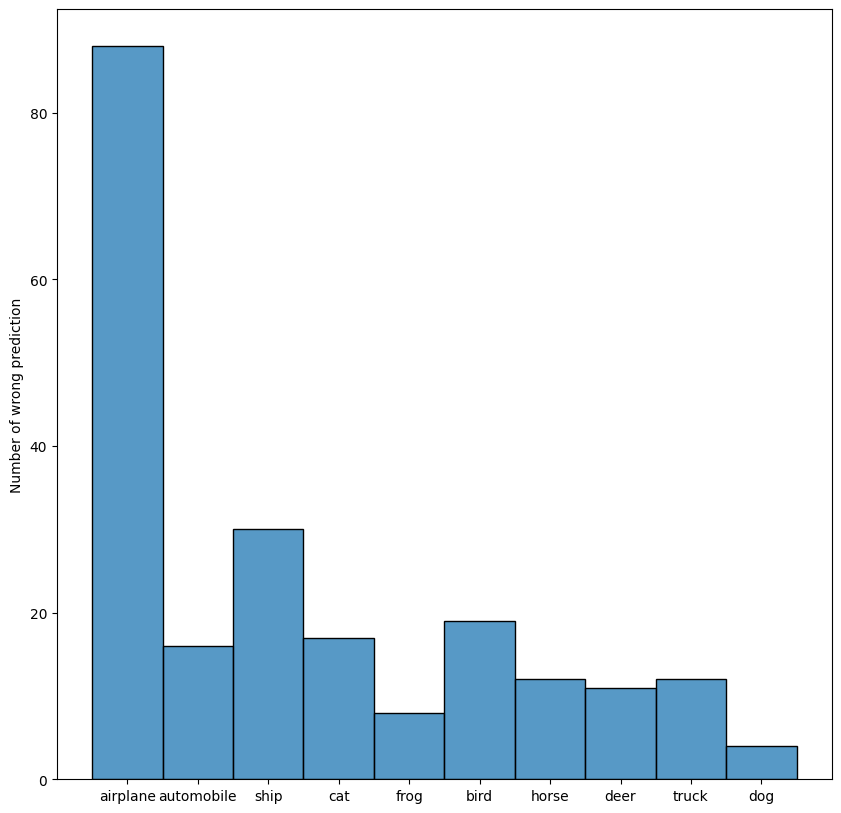

In [46]:
plot_error_hist(label_wrong_pred,label_dict)

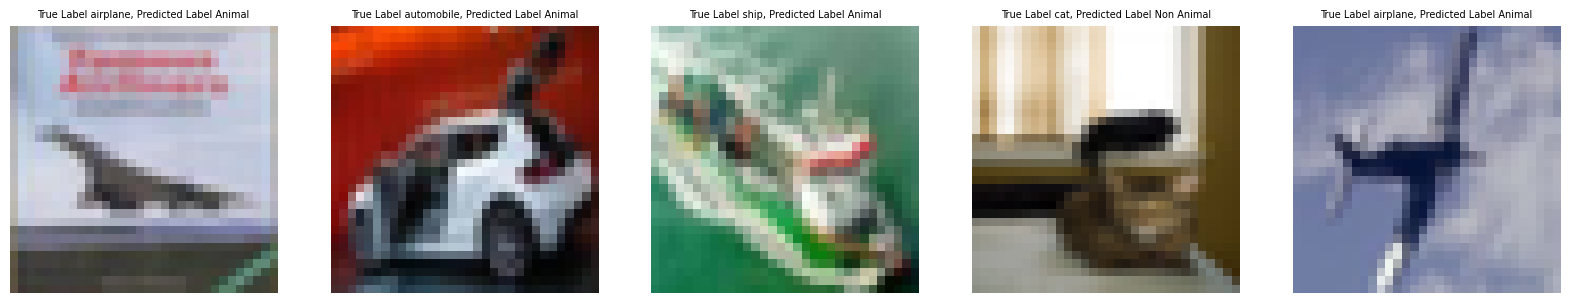

In [47]:

plt.figure(figsize=(20,20))
for i in range(0,5):
    plt.subplot(1,5,i+1)
    plt.imshow(test_images[index_error[i]], cmap=plt.cm.gray)
    plt.title("True Label {}, Predicted Label {}".format(label_dict[int(test_labels[index_error[i]])],prediction_label[index_error[i]]),fontsize = 7)
    plt.axis('off')

## Resnet50

In [48]:
res_net_predict = res_trained.predict(test_dataset_res)
res_net_predict = res_net_predict.reshape(-1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step


In [49]:
error_label,index_error,label_wrong_pred = find_error(res_net_predict,test_label_bin,test_labels)

The number airplane wrong prediction are: 23
The number automobile wrong prediction are: 3
The number bird wrong prediction are: 26
The number cat wrong prediction are: 14
The number deer wrong prediction are: 9
The number dog wrong prediction are: 4
The number frog wrong prediction are: 8
The number horse wrong prediction are: 16
The number ship wrong prediction are: 5
The number truck wrong prediction are: 4


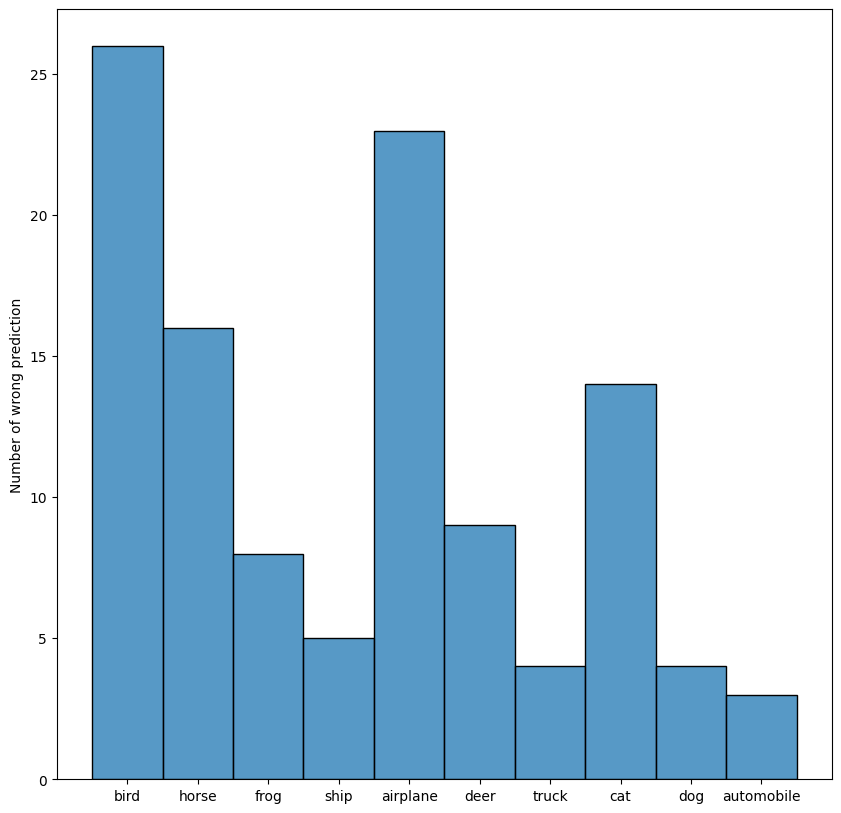

In [50]:
plot_error_hist(label_wrong_pred,label_dict)

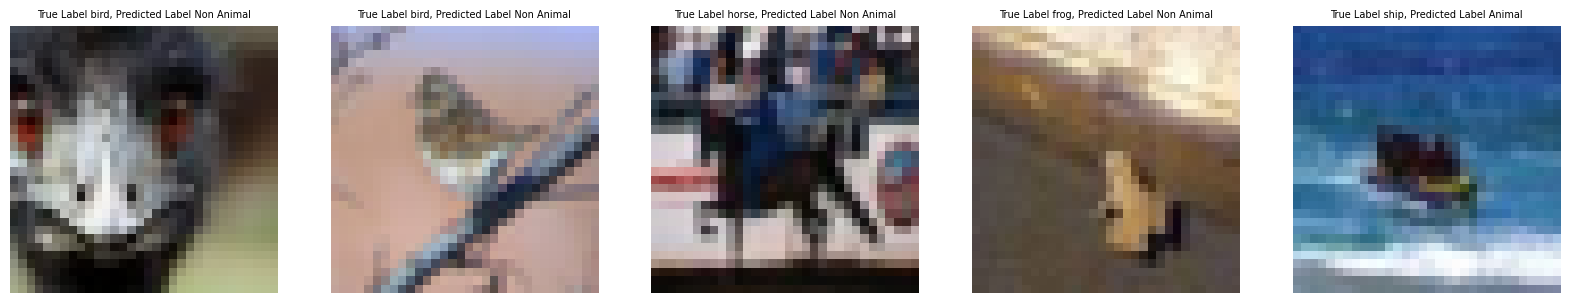

In [52]:

plt.figure(figsize=(20,20))
for i in range(0,5):
    plt.subplot(1,5,i+1)
    plt.imshow(test_images[index_error[i]], cmap=plt.cm.gray)
    plt.title("True Label {}, Predicted Label {}".format(label_dict[int(test_labels[index_error[i]])],error_label[index_error[i]]),fontsize = 7)
    plt.axis('off')